# Lab 10: Lunar Landing using Reinforcement Learning

Some cells in this lab throw errors, but the major functionality works. The errors are due to compatability issues among some dependencies. Notably, the gym package is deprecated and should be replaced with gymnasium and I may need to rollback from tensorflow 2.18 to 2.15

In [1]:
import time
from collections import deque, namedtuple

import gym
import numpy as np
import lib.utils

# to render Lunar Lander environment
import PIL.Image
from pyvirtualdisplay import Display

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

## Setup

In [2]:
# Set up a virtual display to render the Lunar Lander environment.
Display(visible=0, size=(840, 480)).start();

# If raises error: FileNotFoundError: [Errno 2] No such file or directory: 'Xvfb'...
# follow these instructions: https://stackoverflow.com/questions/72853097/pyvirtual-display-and-xvfb-on-macos-latest

In [2]:
# Set the random seed for TensorFlow
tf.random.set_seed(lib.utils.SEED)

In [3]:
# Set the hyperparameters
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate  
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps

## Load the Environment

In [4]:
print(gym.__version__)

0.26.2


In [5]:
# Load the LunarLander-v2 environment from the gym library by using the `.make()` method. 
# LunarLander-v2 is a version of the Lunar Lander environment.
env = gym.make("LunarLander-v2", render_mode="human")

/Users/chrisbrickey/Development/lossless3/.venv/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [6]:
# Use the .reset() method to reset the environment to the initial state. 
# CAUTION: Sometimes causes program to hang on my local machine.
env.reset()

(array([ 0.00379801,  1.417627  ,  0.38469282,  0.29807884, -0.00439426,
        -0.08713865,  0.        ,  0.        ], dtype=float32),
 {})

In [7]:
# The lander starts at the top center of the environment and we can render the first frame of the environment by using the .render() method.

# original code from coursework; mismatch of versions
# PIL.Image.fromarray(env.render(mode='rgb_array'))

# updated code
# This fails because env.render() returns None
# Consider updating to gymnasium. gym is deprecated.
PIL.Image.fromarray(env.render())

AttributeError: 'NoneType' object has no attribute '__array_interface__'

In [8]:
# In order to build the neural network later, we need to know the size of the state vector and the number of valid actions. 
# We can get this information from our environment by using the .observation_space.shape and action_space.n methods, respectively.
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

# Expected Values
# State Shape: (8,)
# Number of actions: 4

State Shape: (8,)
Number of actions: 4


## Interacting with the Gym Environment

The gym library implements the "agent-environment loop".
* To begin an episode, reset the environment to an initial state by using the `.reset()` method.
* Then use the `.step()` method to run a single time step of the environment's dynamics.

Actions:
* Do nothing = 0
* Fire right engine = 1
* Fire main engine = 2
* Fire left engine = 3

In [9]:
# Reset the environment and get the initial state
# Causes program to hang on my local machine
current_state = env.reset()

In [10]:
# Select an action
action = 0

# Run a single time step of the environment's dynamics with the given action.
# next_state, reward, done, _ = env.step(action) # outdated version
next_state, reward, done, _, _ = env.step(action)

# Display table with values.
lib.utils.display_table(current_state, action, next_state, reward, done)

# Replace the `current_state` with the state after the action is taken
current_state = next_state

AttributeError: module 'numpy' has no attribute 'bool8'

## Deep Q-Learning

Create the $Q$ and target $\hat Q$ networks and set the optimizer. Remember that the Deep $Q$-Network (DQN) is a neural network that approximates the action-value function $Q(s,a)\approx Q^*(s,a)$. It does this by learning how to map states to $Q$ values.

To solve the Lunar Lander environment, employ a DQN with the following architecture:

* An `Input` layer that takes `state_size` as input.

* A `Dense` layer with `64` units and a `relu` activation function.

* A `Dense` layer with `64` units and a `relu` activation function.

* A `Dense` layer with `num_actions` units and a `linear` activation function. This will be the output layer of our network.


In the cell below you should create the $Q$-Network and the target $\hat Q$-Network using the model architecture described above. Remember that both the $Q$-Network and the target $\hat Q$-Network have the same architecture.

Lastly, set `Adam` as the optimizer with a learning rate equal to `ALPHA`.

In [11]:
# UNQ_C1
# GRADED CELL

# Create the Q-Network
q_network = Sequential([
    ### START CODE HERE ### 
    tf.keras.layers.Input(shape=(state_size)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_actions) 
    ### END CODE HERE ### 
    ])

# Create the target Q^-Network
target_q_network = Sequential([
    ### START CODE HERE ### 
    tf.keras.layers.Input(shape=(state_size)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_actions)     
    ### END CODE HERE ###
    ])

### START CODE HERE ### 
optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)
### END CODE HERE ###

# This passes all tests in the coursework.

In [12]:
# UNIT TEST
from public_tests import *

test_network(q_network)
test_network(target_q_network)
test_optimizer(optimizer, ALPHA) 

# This throws exception which I believe is related to verson of tensorflow. Consider reverting to tensorflow version 2.15.

AttributeError: The layer sequential has never been called and thus has no defined input.

In [13]:
# Experience Replay
# When an agent interacts with the environment, the states, actions, and rewards the agent experiences are sequential by nature. 
# If the agent tries to learn from these consecutive experiences it can run into problems due to the strong correlations between them. 
# To avoid this, we employ a technique known as Experience Replay to generate uncorrelated experiences for training our agent. 
# Experience replay consists of storing the agent's experiences (i.e the states, actions, and rewards the agent receives) in a memory buffer and then sampling a random mini-batch of experiences from the buffer to do the learning. 
# The experience tuples $(S_t, A_t, R_t, S_{t+1})$ will be added to the memory buffer at each time step as the agent interacts with the environment.

# Store experiences as named tuples for convenience.
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

## Deep Q-Learning Algorithm with Experience Replay

In [14]:
# UNQ_C2
# GRADED FUNCTION: calculate_loss

def compute_loss(experiences, gamma, q_network, target_q_network):
    """ 
    Calculates the loss.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Keras model for predicting the targets
          
    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """

    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences
    
    # Compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
    
    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
    ### START CODE HERE ### 
    
    # Bellman Equation: Q(s, a) = R(s) + discount_factor*(max(Q(s', a')
    # where R(s) is the reward at the current state; this is represented by variable 'rewards'
    # where max(Q(s', a') is the highest Q value of all of the options at state s prime (s')
    # discount_factor is represented by variable 'gamma'
    
    highest_q_at_s_prime = max_qsa * (1 - done_vals)
    y_targets = rewards + (gamma * highest_q_at_s_prime)
    ### END CODE HERE ###
    
    # Get the q_values and reshape to match y_targets
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))
        
    # Compute the loss
    ### START CODE HERE ### 
    loss = MSE(y_targets, q_values)
    ### END CODE HERE ### 
    
    return loss

# The above function passes all tests in coursework.

In [15]:
# UNIT TEST    
test_compute_loss(compute_loss)

All tests passed!


## Update Network Weights

In [16]:
@tf.function
def agent_learn(experiences, gamma):
    """
    Updates the weights of the Q networks.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
    
    """
    
    # Calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)
    
    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of target q_network
    lib.utils.update_target_network(q_network, target_q_network)

## Train the Agent

In [19]:
start = time.time()

num_episodes = 2000
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):
    
    # Reset the environment to the initial state and get the initial state
    state = env.reset() # outdated version
    state = env.reset()[0]
    
    total_points = 0
    
    for t in range(max_num_timesteps):
        
        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
        q_values = q_network(state_qn)
        action = lib.utils.get_action(q_values, epsilon)
        
        # Take action A and receive reward R and the next state S'
        # next_state, reward, done, _ = env.step(action) # outdated version
        next_state, reward, done, _, _ = env.step(action)
        
        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))
        
        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = lib.utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
        
        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = lib.utils.get_experiences(memory_buffer)
            
            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            agent_learn(experiences, GAMMA)
        
        state = next_state.copy()
        total_points += reward
        
        if done:
            break
            
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
    
    # Update the ε value
    epsilon = lib.utils.get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('lunar_lander_model.h5')
        break
        
tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: -152.27
Episode 200 | Total point average of the last 100 episodes: -83.195
Episode 300 | Total point average of the last 100 episodes: -44.70
Episode 400 | Total point average of the last 100 episodes: 2.8368
Episode 500 | Total point average of the last 100 episodes: 145.07
Episode 570 | Total point average of the last 100 episodes: 199.87

Episode 571 | Total point average of the last 100 episodes: 200.27

Environment solved in 571 episodes!

Total Runtime: 6674.83 s (111.25 min)


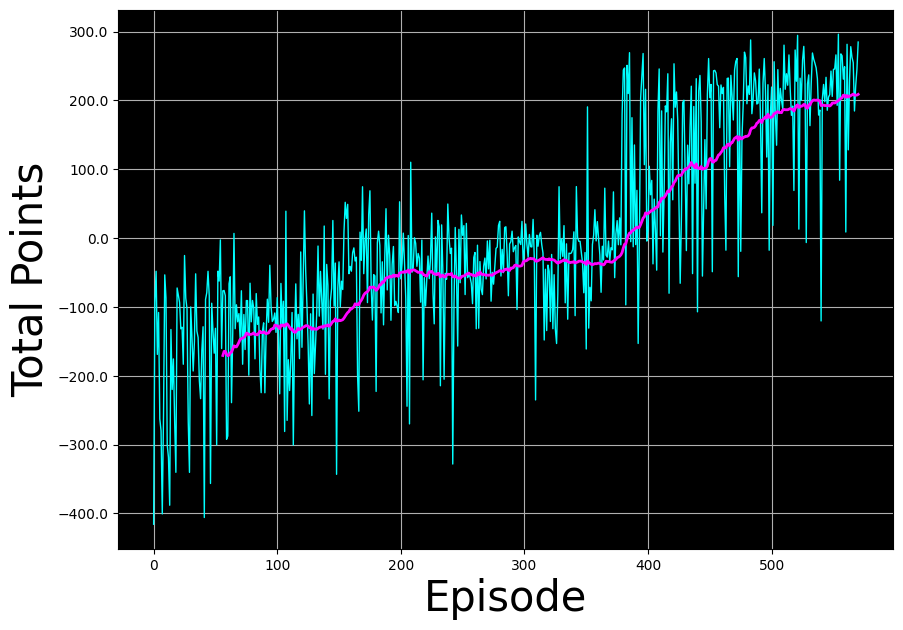

In [21]:
# Plot the total point history along with the moving average
lib.utils.plot_history(total_point_history)

## Create video of agent

In [18]:
# Modifications made to lib.utils.create_video

def create_video(filename, env, q_network, fps=30):
    with imageio.get_writer(filename, fps=fps) as video:
        done = False
#        state = env.reset()
#        frame = env.render(mode="rgb_array")
        state = env.reset()[0]
        frame = env.render()
        video.append_data(frame)
        while not done:    
            state = np.expand_dims(state, axis=0)
            q_values = q_network(state)
            action = np.argmax(q_values.numpy()[0])
#            state, _, done, _ = env.step(action)
#            frame = env.render(mode="rgb_array")
            state, _, done, _, _ = env.step(action)
            frame = env.render()
            video.append_data(frame)

In [22]:
# Suppress warnings from imageio
import logging
logging.getLogger().setLevel(logging.ERROR)

In [25]:
filename = "./videos/lunar_lander.mp4"

lib.utils.create_video(filename, env, q_network)
lib.utils.embed_mp4(filename)

ValueError: Could not find a backend to open `./videos/lunar_lander.mp4`` with iomode `w?`.
Based on the extension, the following plugins might add capable backends:
  FFMPEG:  pip install imageio[ffmpeg]
  pyav:  pip install imageio[pyav]